<a href="https://colab.research.google.com/github/ramsesp2162/Data_projects/blob/main/chicagoschools_gv_ETL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


****

**Data Source:** Chicago Police Department and Chicago Board of Education

**RDB Construction:**
 Combine the school data and shooting incidents data to create a strong database that includes important details about how well schools are doing and
 where shooting incidents happen. This way, we can see if there's a connection between school performance and safety in different areas.

**Geospatial Analysis:**
  Provide data analysts with an interactive map of the Chicago area with points detail Schools and a heatmap providing insight on hotzones for armed crimes.
****

In [ ]:
pip install folium

In [ ]:
#Importing our tools
import pandas as pd
import numpy as np
import psycopg2
import folium

In [ ]:
###EXTRACT###
#Upload data from Google drive using sharing links
armed_inc = pd.read_csv('https://docs.google.com/spreadsheets/d/1gVUnmaYxV5aRdT6_eunyk7PbQBjatoM5kv7SrNYv7rE/gviz/tq?tqx=out:csv')
school_perf = pd.read_csv('https://docs.google.com/spreadsheets/d/1gM5ihcSVUOu97-N4lGEYbuFj183f7Hcx7k2h_D8Uwr0/gviz/tq?tqx=out:csv')

<ipython-input-159-ee0d7268cd7e>:3: DtypeWarning: Columns (25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  armed_inc = pd.read_csv('https://docs.google.com/spreadsheets/d/1gVUnmaYxV5aRdT6_eunyk7PbQBjatoM5kv7SrNYv7rE/gviz/tq?tqx=out:csv')


armed_inc -> csv containg details on shooting incidents in Chicago, including location, type of incident, and victim information

school_perf -> csv containg details about public schools in Chicago, including safety grade, location and administrative codes for district and area designation

In [ ]:
print('School Performance:',school_perf.shape)
print('Shooting Incidents:',armed_inc.shape)

School Performance: (566, 79)
Shooting Incidents: (57753, 38)


In [ ]:
armed_inc.head(3)

,CASE_NUMBER,DATE,BLOCK,VICTIMIZATION_PRIMARY,INCIDENT_PRIMARY,GUNSHOT_INJURY_I,UNIQUE_ID,ZIP_CODE,WARD,COMMUNITY_AREA,...,MONTH,DAY_OF_WEEK,HOUR,LOCATION_DESCRIPTION,STATE_HOUSE_DISTRICT,STATE_SENATE_DISTRICT,UPDATED,LATITUDE,LONGITUDE,LOCATION
0,A000157,01/01/1996 4:40:00 AM,4300 S STATE ST,HOMICIDE,HOMICIDE,YES,HOM-A000157-#1,60609.0,3.0,GRAND BOULEVARD,...,1,2,4,AUTO,6.0,3.0,12/21/2010 7:55:15 AM,41.816122,-87.626845,POINT (-87.62684534612 41.816121654142)
1,A000157,01/01/1996 4:40:00 AM,4300 S STATE ST,HOMICIDE,HOMICIDE,YES,HOM-A000157-#2,60609.0,3.0,GRAND BOULEVARD,...,1,2,4,AUTO,6.0,3.0,12/21/2010 7:54:25 AM,41.816122,-87.626845,POINT (-87.62684534612 41.816121654142)
2,A003071,01/01/1996 12:15:00 AM,3400 W CHICAGO AVE,HOMICIDE,HOMICIDE,YES,HOM-A003071-#1,60651.0,27.0,HUMBOLDT PARK,...,1,2,0,STREET,10.0,5.0,08/25/2009 2:50:36 PM,41.896093,-87.713481,POINT (-87.713480941301 41.896093095858)


In [ ]:
school_perf.head(3)

,School ID,Name of School,"Elementary, Middle, or High School",Street Address,City,State,ZIP Code,Phone Number,Link,Network Manager,...,RCDTS Code,X_COORDINATE,Y_COORDINATE,Latitude,Longitude,Community Area Number,Community Area Name,Ward,Police District,Location
0,609966,Charles G Hammond Elementary School,ES,2819 W 21st Pl,Chicago,IL,60623,(773) 535-4580,http://schoolreports.cps.edu/SchoolProgressRep...,Pilsen-Little Village Elementary Network,...,150000000000000,1157809.015,1889554.623,41.852691,-87.696278,30,SOUTH LAWNDALE,12,10,"(41.85269133, -87.69627777)"
1,610539,Marvin Camras Elementary School,ES,3000 N Mango Ave,Chicago,IL,60634,(773) 534-2960,http://schoolreports.cps.edu/SchoolProgressRep...,Fullerton Elementary Network,...,150000000000000,1137482.296,1919394.900,41.934966,-87.770165,19,BELMONT CRAGIN,30,25,"(41.93496641, -87.77016525)"
2,609852,Eliza Chappell Elementary School,ES,2135 W Foster Ave,Chicago,IL,60625,(773) 534-2390,http://schoolreports.cps.edu/SchoolProgressRep...,Ravenswood-Ridge Elementary Network,...,150000000000000,1161016.902,1934466.545,41.975867,-87.683254,4,LINCOLN SQUARE,47,20,"(41.975867, -87.68325438)"


In [ ]:
# .dtypes function doesnt help much since it only shows a portion of the data types
school_perf.dtypes

School ID                              int64
Name of School                        object
Elementary, Middle, or High School    object
Street Address                        object
City                                  object
                                       ...  
Community Area Number                  int64
Community Area Name                   object
Ward                                   int64
Police District                        int64
Location                              object
Length: 79, dtype: object

In [ ]:
armed_inc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57753 entries, 0 to 57752
Data columns (total 38 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CASE_NUMBER                   57753 non-null  object 
 1   DATE                          57753 non-null  object 
 2   BLOCK                         57753 non-null  object 
 3   VICTIMIZATION_PRIMARY         57753 non-null  object 
 4   INCIDENT_PRIMARY              57753 non-null  object 
 5   GUNSHOT_INJURY_I              57753 non-null  object 
 6   UNIQUE_ID                     57753 non-null  object 
 7   ZIP_CODE                      57748 non-null  float64
 8   WARD                          57748 non-null  float64
 9   COMMUNITY_AREA                57748 non-null  object 
 10  STREET_OUTREACH_ORGANIZATION  57753 non-null  object 
 11  AREA                          57748 non-null  float64
 12  DISTRICT                      57748 non-null  float64
 13  B

In [ ]:
school_perf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 79 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   School ID                                         566 non-null    int64  
 1   Name of School                                    566 non-null    object 
 2   Elementary, Middle, or High School                566 non-null    object 
 3   Street Address                                    566 non-null    object 
 4   City                                              566 non-null    object 
 5   State                                             566 non-null    object 
 6   ZIP Code                                          566 non-null    int64  
 7   Phone Number                                      566 non-null    object 
 8   Link                                              565 non-null    object 
 9   Network Manager      

# **What data will be dropped?**

Looking at the yields from the .info function, it is clear that there is a lot of detail on the academic performance for each school. Our objective is to compare the performance of each school based on the frequency of violent/armed incidents.

---

* For the first table, I want to filter out information that might not be entirely relevant to the purpose of this database, which is to analyze the impact of gun violence in the area. This table will have the SCHOOL_ID column as the primary key since each school is assigned a unique identifier. We also have the DISTRICT and COMMUNITY_AREA columns that we will use to link to the Armed incidents data.

 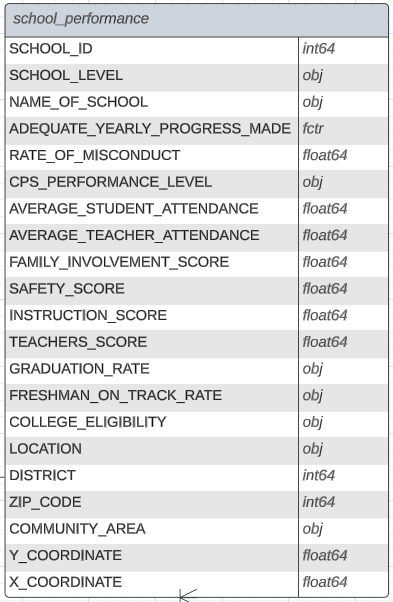

In [ ]:
#First we will make the school performance table with data that is relevant to our analysis
school_performance = school_perf.filter(['School ID', 'Elementary, Middle, or High School', 'Name of School',
                                         'Adequate Yearly Progress Made?', 'Rate of Misconducts (per 100 students)',
                                         'CPS Performance Policy Level', 'Average Student Attendance', 'Average Teacher Attendance',
                                         'Family Involvement Score', 'Safety Score', 'Instruction Score', 'Teachers Score',
                                         'Graduation Rate %', 'Freshman on Track Rate %', 'College Eligibility %', 'Location',
                                         'Police District', 'ZIP Code', 'Community Area Name', 'Y_COORDINATE', 'X_COORDINATE'])
school_performance.head(5)

,School ID,"Elementary, Middle, or High School",Name of School,Adequate Yearly Progress Made?,Rate of Misconducts (per 100 students),CPS Performance Policy Level,Average Student Attendance,Average Teacher Attendance,Family Involvement Score,Safety Score,...,Teachers Score,Graduation Rate %,Freshman on Track Rate %,College Eligibility %,Location,Police District,ZIP Code,Community Area Name,Y_COORDINATE,X_COORDINATE
0,609966,ES,Charles G Hammond Elementary School,No,8.5,Level 2,95.3,95.2,NaN,40.0,...,NaN,NDA,NDA,NDA,"(41.85269133, -87.69627777)",10,60623,SOUTH LAWNDALE,1889554.623,1157809.015
1,610539,ES,Marvin Camras Elementary School,No,4.3,Not Enough Data,95.1,0.0,58.0,54.0,...,88.0,NDA,NDA,NDA,"(41.93496641, -87.77016525)",25,60634,BELMONT CRAGIN,1919394.900,1137482.296
2,609852,ES,Eliza Chappell Elementary School,Yes,2.9,Level 1,95.1,96.7,65.0,70.0,...,48.0,NDA,NDA,NDA,"(41.975867, -87.68325438)",20,60625,LINCOLN SQUARE,1934466.545,1161016.902
3,609835,ES,Daniel R Cameron Elementary School,No,153.9,Level 3,92.6,96.2,NaN,42.0,...,NaN,NDA,NDA,NDA,"(41.90378521, -87.71796315)",25,60651,HUMBOLDT PARK,1908130.068,1151767.546
4,610521,ES,Sir Miles Davis Magnet Elementary Academy,No,57.8,Level 3,93.0,94.5,NaN,35.0,...,NaN,NDA,NDA,NDA,"(41.77122181, -87.66656657)",7,60636,WEST ENGLEWOOD,1859929.018,1166133.893


In [ ]:
school_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   School ID                               566 non-null    int64  
 1   Elementary, Middle, or High School      566 non-null    object 
 2   Name of School                          566 non-null    object 
 3   Adequate Yearly Progress Made?          566 non-null    object 
 4   Rate of Misconducts (per 100 students)  566 non-null    float64
 5   CPS Performance Policy Level            566 non-null    object 
 6   Average Student Attendance              565 non-null    float64
 7   Average Teacher Attendance              566 non-null    float64
 8   Family Involvement Score                297 non-null    float64
 9   Safety Score                            513 non-null    float64
 10  Instruction Score                       513 non-null    float6

In [ ]:
#Before anything, I need to change the column names to make the data consistent for keys and foreign keys to other tables
school_performance.columns = school_performance.columns.str.replace(',', '').str.replace('%', '').str.replace('?', '').str.replace(' ', '_').str.upper()
school_performance.head(3)

<ipython-input-168-59b4a5216db4>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  school_performance.columns = school_performance.columns.str.replace(',', '').str.replace('%', '').str.replace('?', '').str.replace(' ', '_').str.upper()


,SCHOOL_ID,ELEMENTARY_MIDDLE_OR_HIGH_SCHOOL,NAME_OF_SCHOOL,ADEQUATE_YEARLY_PROGRESS_MADE,RATE_OF_MISCONDUCTS_(PER_100_STUDENTS),CPS_PERFORMANCE_POLICY_LEVEL,AVERAGE_STUDENT_ATTENDANCE,AVERAGE_TEACHER_ATTENDANCE,FAMILY_INVOLVEMENT_SCORE,SAFETY_SCORE,...,TEACHERS_SCORE,GRADUATION_RATE_,FRESHMAN_ON_TRACK_RATE_,COLLEGE_ELIGIBILITY_,LOCATION,POLICE_DISTRICT,ZIP_CODE,COMMUNITY_AREA_NAME,Y_COORDINATE,X_COORDINATE
0,609966,ES,Charles G Hammond Elementary School,No,8.5,Level 2,95.3,95.2,NaN,40.0,...,NaN,NDA,NDA,NDA,"(41.85269133, -87.69627777)",10,60623,SOUTH LAWNDALE,1889554.623,1157809.015
1,610539,ES,Marvin Camras Elementary School,No,4.3,Not Enough Data,95.1,0.0,58.0,54.0,...,88.0,NDA,NDA,NDA,"(41.93496641, -87.77016525)",25,60634,BELMONT CRAGIN,1919394.900,1137482.296
2,609852,ES,Eliza Chappell Elementary School,Yes,2.9,Level 1,95.1,96.7,65.0,70.0,...,48.0,NDA,NDA,NDA,"(41.975867, -87.68325438)",20,60625,LINCOLN SQUARE,1934466.545,1161016.902


In [ ]:
# some of the names are too long which could make it harder for data analysts to query our data later on
new_names = {
   'ELEMENTARY_MIDDLE_OR_HIGH_SCHOOL':'SCHOOL_LEVEL',
   'RATE_OF_MISCONDUCTS_(PER_100_STUDENTS)':'RATE_OF_MISCONDUCT',
   'CPS_PERFORMANCE_POLICY_LEVEL':'CPS_PERFORMANCE_LEVEL',
   'FRESHMAN_ON_TRACK_RATE_':'FRESHMAN_ON_TRACK_RATE',
   'GRADUATION_RATE_':'GRADUATION_RATE',
   'COLLEGE_ELIGIBILITY_':'COLLEGE_ELIGIBILITY',
   'POLICE_DISTRICT':'DISTRICT',
   'COMMUNITY_AREA_NAME':'COMMUNITY_AREA'
}

school_performance.rename(columns = new_names, inplace = True)

In [ ]:
#I want to convert the 'Yearly adequate progress' column into a factor/categorical since its either a 'yes' or 'no' column, we will also do the same for the 'CPS Performance Level' Column.
school_performance['CPS_PERFORMANCE_LEVEL'] = pd.Categorical(school_performance['CPS_PERFORMANCE_LEVEL'])
school_performance['ADEQUATE_YEARLY_PROGRESS_MADE'] = pd.Categorical(school_performance['ADEQUATE_YEARLY_PROGRESS_MADE'])
school_performance.dtypes

SCHOOL_ID                           int64
SCHOOL_LEVEL                       object
NAME_OF_SCHOOL                     object
ADEQUATE_YEARLY_PROGRESS_MADE    category
RATE_OF_MISCONDUCT                float64
CPS_PERFORMANCE_LEVEL            category
AVERAGE_STUDENT_ATTENDANCE        float64
AVERAGE_TEACHER_ATTENDANCE        float64
FAMILY_INVOLVEMENT_SCORE          float64
SAFETY_SCORE                      float64
INSTRUCTION_SCORE                 float64
TEACHERS_SCORE                    float64
GRADUATION_RATE                    object
FRESHMAN_ON_TRACK_RATE             object
COLLEGE_ELIGIBILITY                object
LOCATION                           object
DISTRICT                            int64
ZIP_CODE                            int64
COMMUNITY_AREA                     object
Y_COORDINATE                      float64
X_COORDINATE                      float64
dtype: object

****
#**Mapping Schools**
I'm looking to improve this dataset by incorporating geolocation data, especially as we go into the analysis of schools and crime in various Chicago communities. Using the location column as a key, I'll be using Folium to create an interactive map. This map will serve as a dynamic tool for data analysts, providing them with an effective means to visually explore and interpret spatial patterns in the dataset.

In [ ]:
#first we will remove the parenthesis in the location column, that way we will be able to use the latitude and longitude coordinates to map every school in the Chicago area
school_performance['LOCATION'] = school_performance['LOCATION'].apply(eval)

In [ ]:
#here we will create our school map and set the first row of the table to be  our center of the map
map_center = [school_performance['LOCATION'].iloc[0][0], school_performance['LOCATION'].iloc[0][1]]
school_map = folium.Map(location=map_center, zoom_start=12)

#here we will add every row as a point labeled with the school's name
for index, row in school_performance.iterrows():
    school_name = row['NAME_OF_SCHOOL']
    coordinates = row['LOCATION']
    # Here we add the name of the school to the pop-up for each point
    folium.Marker(location=coordinates, popup=school_name).add_to(school_map)

#saving the map to an html to preview
school_map.save('school_map.html')

In [ ]:
school_map

****
# **Armed Incidents Data**

We want to split the armed_inc dataframe into multiple tables, each with their own set of data extracted from the original database.
These three tables will be:

*   **Shooting Incidents**: this table will contain info on case number, location of the crime commited and the date when it was commited.

*   **Crime Classification**: This will also contain the case number to link it back to our "Lethal and Non-lethal Shootings" table. This table will also contain classification details on the crime commited, whether a gun was used, the type of victimization, the FBI classification of the crime, etc...

*  **Victim Info**: This table will contain data on the victims of the crimes listed on the database, basic information like age, sex and race along with the case number as the key back to our "Lethal and Non-lethal Shootings" table.



In [ ]:
armed_inc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57753 entries, 0 to 57752
Data columns (total 38 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CASE_NUMBER                   57753 non-null  object 
 1   DATE                          57753 non-null  object 
 2   BLOCK                         57753 non-null  object 
 3   VICTIMIZATION_PRIMARY         57753 non-null  object 
 4   INCIDENT_PRIMARY              57753 non-null  object 
 5   GUNSHOT_INJURY_I              57753 non-null  object 
 6   UNIQUE_ID                     57753 non-null  object 
 7   ZIP_CODE                      57748 non-null  float64
 8   WARD                          57748 non-null  float64
 9   COMMUNITY_AREA                57748 non-null  object 
 10  STREET_OUTREACH_ORGANIZATION  57753 non-null  object 
 11  AREA                          57748 non-null  float64
 12  DISTRICT                      57748 non-null  float64
 13  B

In [ ]:
armed_inc.head(3)

,CASE_NUMBER,DATE,BLOCK,VICTIMIZATION_PRIMARY,INCIDENT_PRIMARY,GUNSHOT_INJURY_I,UNIQUE_ID,ZIP_CODE,WARD,COMMUNITY_AREA,...,MONTH,DAY_OF_WEEK,HOUR,LOCATION_DESCRIPTION,STATE_HOUSE_DISTRICT,STATE_SENATE_DISTRICT,UPDATED,LATITUDE,LONGITUDE,LOCATION
0,A000157,01/01/1996 4:40:00 AM,4300 S STATE ST,HOMICIDE,HOMICIDE,YES,HOM-A000157-#1,60609.0,3.0,GRAND BOULEVARD,...,1,2,4,AUTO,6.0,3.0,12/21/2010 7:55:15 AM,41.816122,-87.626845,POINT (-87.62684534612 41.816121654142)
1,A000157,01/01/1996 4:40:00 AM,4300 S STATE ST,HOMICIDE,HOMICIDE,YES,HOM-A000157-#2,60609.0,3.0,GRAND BOULEVARD,...,1,2,4,AUTO,6.0,3.0,12/21/2010 7:54:25 AM,41.816122,-87.626845,POINT (-87.62684534612 41.816121654142)
2,A003071,01/01/1996 12:15:00 AM,3400 W CHICAGO AVE,HOMICIDE,HOMICIDE,YES,HOM-A003071-#1,60651.0,27.0,HUMBOLDT PARK,...,1,2,0,STREET,10.0,5.0,08/25/2009 2:50:36 PM,41.896093,-87.713481,POINT (-87.713480941301 41.896093095858)


In [ ]:
#Checking the columns that were left out in the previous dataframe
middle_columns = armed_inc.iloc[:, 10:28]
middle_columns.head(3)

,STREET_OUTREACH_ORGANIZATION,AREA,DISTRICT,BEAT,AGE,SEX,RACE,VICTIMIZATION_FBI_CD,INCIDENT_FBI_CD,VICTIMIZATION_FBI_DESCR,INCIDENT_FBI_DESCR,VICTIMIZATION_IUCR_CD,INCIDENT_IUCR_CD,VICTIMIZATION_IUCR_SECONDARY,INCIDENT_IUCR_SECONDARY,HOMICIDE_VICTIM_FIRST_NAME,HOMICIDE_VICTIM_MI,HOMICIDE_VICTIM_LAST_NAME
0,Acclivus Grand Boulevard,1.0,2.0,215.0,0-19,M,BLK,01A,01A,HOMICIDE - 1ST OR 2ND DEGREE (INDEX),HOMICIDE - 1ST OR 2ND DEGREE (INDEX),01XX,01XX,NaN,NaN,LAVELL A,A,SMITH
1,Acclivus Grand Boulevard,1.0,2.0,215.0,0-19,M,BLK,01A,01A,HOMICIDE - 1ST OR 2ND DEGREE (INDEX),HOMICIDE - 1ST OR 2ND DEGREE (INDEX),01XX,01XX,NaN,NaN,STACY,NaN,PORTER
2,ALSO Humboldt Park,4.0,11.0,1121.0,30-39,M,BLK,01A,01A,HOMICIDE - 1ST OR 2ND DEGREE (INDEX),HOMICIDE - 1ST OR 2ND DEGREE (INDEX),01XX,01XX,NaN,NaN,MICHAEL,NaN,HARRIS


In [ ]:
#before splitting the data I want to only get data from the hear 2010 to the present since this data goes back to the early 90's and the school performance data is more recent.
#converting 'DATE' column from obj to datetime
armed_inc['DATE'] = pd.to_datetime(armed_inc['DATE'], format='%m/%d/%Y %I:%M:%S %p')

#filtering from 2010 - Present
armed_inc = armed_inc[armed_inc['DATE'].dt.year >= 2010]
armed_inc.shape

(44996, 38)

In [ ]:
#Now we create our tables for shooting icidents, crime classification and victim info
shooting_incidents = armed_inc.filter(['UNIQUE_ID', 'CASE_NUMBER', 'DATE', 'ZIP_CODE', 'COMMUNITY_AREA', 'DISTRICT','LONGITUDE', 'LATITUDE'])
crime_classification = armed_inc.filter(['UNIQUE_ID', 'GUNSHOT_INJURY_I', 'VICTIMIZATION_PRIMARY', 'INCIDENT_PRIMARY', 'VICTIMIZATION_FBI_DESCR', 'INCIDENT_FBI_DESCR', 'LOCATION_DESCRIPTION'])
victim_info = armed_inc.filter(['CASE_NUMBER', 'UNIQUE_ID', 'AGE', 'SEX', 'RACE', 'HOMICIDE_VICTIM_FIRST_NAME', 'HOMICIDE_VICTIM_MI', 'HOMICIDE_VICTIM_LAST_NAME'])

#printing the shape for each table
print('Shooting Incidents:', shooting_incidents.shape)
print('Crime Classification:', crime_classification.shape)
print('Victim Classification:', victim_info.shape)

Shooting Incidents: (44996, 8)
Crime Classification: (44996, 7)
Victim Classification: (44996, 8)


#**Shooting Incidents**

This Dataframe will contain information on the identifiers and location data for shooting incidents. This table will be linked to the School Performance table through the DISTRICT column. We will also be using the data on this table to create our heatmap of shootings later on.
****
* **UNIQUE_ID**: Unique identifier for each row of data, will be used to link to Crime Classification and Victim Info tables.
* **CASE_NUMBER**: Number used to identify each shooting incident, some rows share the same case number since there might have been multiple shooting incidents or charges brought up in a single case.
* **DATE**: Date when the incident occured.
* **ZIP_CODE**:Zip code for area where shooting happened.
* **COMMUNITY_AREA**: Name of the community where the shooting happened.
* **DISTRICT**: Police district number (primary key).
* **LONGITUDE**: longitude coordinate.
* **LATITUDE**: latitude coordinate.

 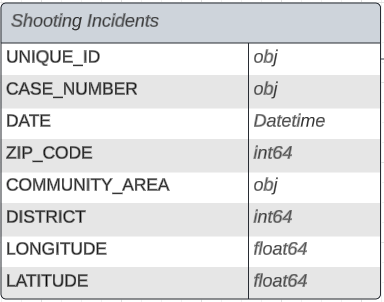

In [ ]:
#We will be using the 'UNIQUE_ID' column for our key since each row in this dataframe has a unique ID assigned to them
armed_inc['UNIQUE_ID'].value_counts()

HOM-JF167335-#1      1
SHOOT-HZ504461-#1    1
SHOOT-HZ504084-#1    1
SHOOT-HZ504099-#1    1
SHOOT-HZ504177-#1    1
                    ..
HOM-JC178163-#1      1
HOM-JC179984-#1      1
HOM-JC182941-#1      1
HOM-JC183040-#2      1
SHOOT-JG482866-#1    1
Name: UNIQUE_ID, Length: 44996, dtype: int64

In [ ]:
#The zip code column in shooting_incidents table is showing as a float and we dont want that since it might cause issues with the zip code column on our schools table
shooting_incidents.dtypes

UNIQUE_ID                 object
CASE_NUMBER               object
DATE              datetime64[ns]
ZIP_CODE                 float64
COMMUNITY_AREA            object
DISTRICT                 float64
LONGITUDE                float64
LATITUDE                 float64
dtype: object

In [ ]:
# we have some NA values in our ZIP_CODE and DISTRICT columns, we need to remove these before we convert any data types
na_zip = shooting_incidents['ZIP_CODE'].isna()
na_zip.value_counts()

False    44995
True         1
Name: ZIP_CODE, dtype: int64

In [ ]:
# Fill NAs with '0000' and conversion to int
shooting_incidents['ZIP_CODE'].fillna('0000', inplace = True)
shooting_incidents['ZIP_CODE'] = shooting_incidents['ZIP_CODE'].astype(int)

#we do the same for the DISTRICT column
shooting_incidents['DISTRICT'].fillna('00', inplace = True)
shooting_incidents['DISTRICT'] = shooting_incidents['DISTRICT'].astype(int)
shooting_incidents.dtypes

UNIQUE_ID                 object
CASE_NUMBER               object
DATE              datetime64[ns]
ZIP_CODE                   int64
COMMUNITY_AREA            object
DISTRICT                   int64
LONGITUDE                float64
LATITUDE                 float64
dtype: object

In [ ]:
#converting 'DATE' column from obj to datetime
shooting_incidents['DATE'] = pd.to_datetime(shooting_incidents['DATE'], format='%m/%d/%Y %I:%M:%S %p')
shooting_incidents.dtypes

UNIQUE_ID                 object
CASE_NUMBER               object
DATE              datetime64[ns]
ZIP_CODE                   int64
COMMUNITY_AREA            object
DISTRICT                   int64
LONGITUDE                float64
LATITUDE                 float64
dtype: object

In [ ]:
#one last look at our shooting_incidents table
shooting_incidents.head(5)

,UNIQUE_ID,CASE_NUMBER,DATE,ZIP_CODE,COMMUNITY_AREA,DISTRICT,LONGITUDE,LATITUDE
3,HOM-JF167335-#1,JF167335,2022-03-08 15:27:00,60660,EDGEWATER,24,-87.657000,41.990570
6,SHOOT-JE203123-#1,JE203123,2021-04-18 16:18:00,60624,NORTH LAWNDALE,11,-87.705355,41.866322
7,HOM-JF242327-#1,JF242327,2022-05-14 17:30:00,60637,WASHINGTON PARK,2,-87.621335,41.790722
8,HOM-JG295019-#1,JG295019,2023-06-09 23:00:00,60612,NEAR WEST SIDE,11,-87.688859,41.877133
9,HOM-JG466533-#1,JG466533,2023-10-17 00:18:00,60619,CHATHAM,6,-87.602285,41.744602


# **Crime Classification**

This Dataframe contains detailed information on the shooting incidents. The chages and details about each incident is listed here. This table will be linked to the **Shooting Incidents** table through the UNIQUE_ID column.
****
* **UNIQUE_ID**: Unique identifier for each row of data, will be used as a key to the **Shooting Incidents** table (Foreign Key).
* **GUNSHOT_INJURY**: This is categorical column that determines wether there was a gunshot injury in the incident.
* **VICTIMIZATION_PRIMARY**: Charges brought up for the victimization of an individual.
* **INCIDENT_PRIMARY**: Charges brought up for incident.
* **VICTIMIZATION_FBI_DESCR**: Description of victimization as shown on the FBI database.
* **INCIDENT_FBI_DESCR**: Description of incident as shown on FBI database.
* **LOCATION_DESCRIPTION**: Description of the place where the incident took place

 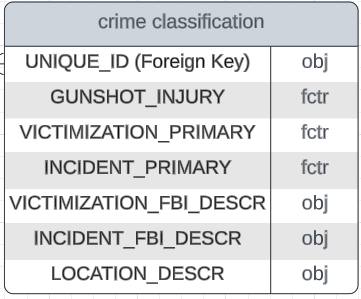


In [ ]:
crime_classification.dtypes

UNIQUE_ID                  object
GUNSHOT_INJURY_I           object
VICTIMIZATION_PRIMARY      object
INCIDENT_PRIMARY           object
VICTIMIZATION_FBI_DESCR    object
INCIDENT_FBI_DESCR         object
LOCATION_DESCRIPTION       object
dtype: object

In [ ]:
# For the Crime classifiers it will be best if they are converted to factors/categoricals
columns = ['GUNSHOT_INJURY_I', 'VICTIMIZATION_PRIMARY', 'INCIDENT_PRIMARY', 'VICTIMIZATION_FBI_DESCR', 'INCIDENT_FBI_DESCR']
crime_classification[columns] = crime_classification[columns].apply(lambda x: pd.Categorical(x))
crime_classification.dtypes

UNIQUE_ID                    object
GUNSHOT_INJURY_I           category
VICTIMIZATION_PRIMARY      category
INCIDENT_PRIMARY           category
VICTIMIZATION_FBI_DESCR    category
INCIDENT_FBI_DESCR         category
LOCATION_DESCRIPTION         object
dtype: object

In [ ]:
# Simplifying column names
crime_classification = crime_classification.rename(columns = {'GUNSHOT_INJURY_I':'GUNSHOT_INJURY',
                                       'LOCATION_DESCRIPTION':'LOCATION_DESCR'})

In [ ]:
#Cleaning data by removing '(INDEX)' from the values in VICTIMIZATION_FBI_DESCR and INCIDENT_FBI_DESCR
dirty_columns = ['VICTIMIZATION_FBI_DESCR','INCIDENT_FBI_DESCR']
for column in dirty_columns:
    crime_classification[column] = crime_classification[column].str.replace(r'\s*\(INDEX\)', '')

crime_classification.head(3)

<ipython-input-188-0165f432a6f8>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  crime_classification[column] = crime_classification[column].str.replace(r'\s*\(INDEX\)', '')


,UNIQUE_ID,GUNSHOT_INJURY,VICTIMIZATION_PRIMARY,INCIDENT_PRIMARY,VICTIMIZATION_FBI_DESCR,INCIDENT_FBI_DESCR,LOCATION_DESCR
3,HOM-JF167335-#1,NO,HOMICIDE,HOMICIDE,HOMICIDE - 1ST OR 2ND DEGREE,HOMICIDE - 1ST OR 2ND DEGREE,APARTMENT
6,SHOOT-JE203123-#1,YES,BATTERY,HOMICIDE,AGGRAVATED BATTERY,HOMICIDE - 1ST OR 2ND DEGREE,PARKING LOT
7,HOM-JF242327-#1,YES,HOMICIDE,HOMICIDE,HOMICIDE - 1ST OR 2ND DEGREE,HOMICIDE - 1ST OR 2ND DEGREE,APARTMENT


In [ ]:
crime_classification.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44996 entries, 3 to 57752
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   UNIQUE_ID                44996 non-null  object  
 1   GUNSHOT_INJURY           44996 non-null  category
 2   VICTIMIZATION_PRIMARY    44996 non-null  category
 3   INCIDENT_PRIMARY         44996 non-null  category
 4   VICTIMIZATION_FBI_DESCR  44671 non-null  object  
 5   INCIDENT_FBI_DESCR       44992 non-null  object  
 6   LOCATION_DESCR           44996 non-null  object  
dtypes: category(3), object(4)
memory usage: 1.8+ MB


# **Victim Info**

The final table relating to shooting incidents will contain data on the victims of these crimes, it will be linked to the **Shooting Incidents** table using the UNIQUE_ID column.
****
* **CASE_NUMBER**: Identifier number that is assigned to each case, may a ppear more than once since there might be multiple victims to a incident.
* **UNIQUE_ID**: Unique identifier assigned to each row of data, used for linking table to **Shooting Incidents** table.
* **AGE**: Age of homicide victim, not exact age but an interval instead.
* **SEX**: Victim's gender.
* **RACE**: Victims race using CPD classifiers (Black (BLK), White (WHI), White Hispanic (WWH), Black Hispanic (WBH), American Indian / Alaskan Native (I), Asian / Pacific Islander (API), and
Unknown (U)).
* **FIRST_NAME**: Victims first name.
* **MI_NAME**: Victim's middle initial.
* **LAST_NAME**: Victims last name.

 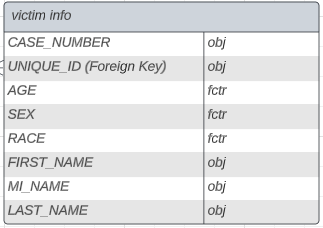

In [ ]:
victim_info.head(3)

,CASE_NUMBER,UNIQUE_ID,AGE,SEX,RACE,HOMICIDE_VICTIM_FIRST_NAME,HOMICIDE_VICTIM_MI,HOMICIDE_VICTIM_LAST_NAME
3,JF167335,HOM-JF167335-#1,60-69,M,BLK,MICHAEL,NaN,MCDADE
6,JE203123,SHOOT-JE203123-#1,20-29,M,BLK,NaN,NaN,NaN
7,JF242327,HOM-JF242327-#1,0-19,M,BLK,EMANUEL,NaN,SCOTT


In [ ]:
# simplifying column names
dirty_names_2 = {'HOMICIDE_VICTIM_FIRST_NAME':'FIRST_NAME',
                 'HOMICIDE_VICTIM_MI':'MI_NAME',
                 'HOMICIDE_VICTIM_LAST_NAME':'LAST_NAME'}

victim_info.rename(columns=dirty_names_2, inplace=True)
victim_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44996 entries, 3 to 57752
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CASE_NUMBER  44996 non-null  object
 1   UNIQUE_ID    44996 non-null  object
 2   AGE          44996 non-null  object
 3   SEX          44996 non-null  object
 4   RACE         44996 non-null  object
 5   FIRST_NAME   8063 non-null   object
 6   MI_NAME      3702 non-null   object
 7   LAST_NAME    8064 non-null   object
dtypes: object(8)
memory usage: 3.1+ MB


In [ ]:
# Converting AGE, SEX and RACE columns to categoricals
to_fctr = ['AGE', 'SEX', 'RACE']
victim_info[to_fctr] = victim_info[to_fctr].apply(lambda x: pd.Categorical(x))
victim_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44996 entries, 3 to 57752
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   CASE_NUMBER  44996 non-null  object  
 1   UNIQUE_ID    44996 non-null  object  
 2   AGE          44996 non-null  category
 3   SEX          44996 non-null  category
 4   RACE         44996 non-null  category
 5   FIRST_NAME   8063 non-null   object  
 6   MI_NAME      3702 non-null   object  
 7   LAST_NAME    8064 non-null   object  
dtypes: category(3), object(5)
memory usage: 2.2+ MB


In [ ]:
# Cleaning up the RACE column to make it a bit more tidy
victim_info['RACE'] = victim_info['RACE'].replace('UNKNOWN', 'U')
victim_info['RACE'].value_counts()

BLK    35038
WWH     7313
WHI     1154
U       1001
WBH      300
API      173
I         17
Name: RACE, dtype: int64

In [ ]:
victim_info.head(10)

,CASE_NUMBER,UNIQUE_ID,AGE,SEX,RACE,FIRST_NAME,MI_NAME,LAST_NAME
3,JF167335,HOM-JF167335-#1,60-69,M,BLK,MICHAEL,NaN,MCDADE
6,JE203123,SHOOT-JE203123-#1,20-29,M,BLK,NaN,NaN,NaN
7,JF242327,HOM-JF242327-#1,0-19,M,BLK,EMANUEL,NaN,SCOTT
8,JG295019,HOM-JG295019-#1,40-49,M,BLK,LEMARK,J,GREEN
9,JG466533,HOM-JG466533-#1,40-49,F,BLK,LEKEYSHA,NaN,TAPLET
10,JG466615,HOM-JG466615-#1,30-39,M,BLK,JAMOL,NaN,TURMAN
12,JG467863,HOM-JG467863-#1,20-29,M,BLK,LEONARD,NaN,BENTLEY
13,JG165073,SHOOT-JG165073-#1,30-39,M,WWH,NaN,NaN,NaN
14,JG165073,SHOOT-JG165073-#2,30-39,M,WWH,NaN,NaN,NaN
15,JG274036,SHOOT-JG274036-#1,30-39,M,WWH,NaN,NaN,NaN


To wrap up the Transformation portion of the ETL we will finish the map that we started at the beginning. Now that we have our shooting incident data we can insert it into the map and create a heatmap. We will be using the longitude and latitude data in our **Shooting Incidents** table to create a heat layer in **SCHOOLS_MAP** based on the frequency of the shootings in the area

In [ ]:
from folium.plugins import HeatMap
#Need to create a seperate dataframe with no NA values in the points data to continue with the heat map
shooting_incidents_heat = shooting_incidents.dropna(subset=['LONGITUDE', 'LATITUDE'])

#here we create our points data and plot it in our heat layer
points = shooting_incidents_heat[[ 'LATITUDE', 'LONGITUDE']].values.tolist()
heat_map = HeatMap(points)

#adding the layer to our school_map
school_map.add_child(heat_map)
school_map


****
#**Loading our Data to AWS**


In [ ]:
#DB connection formulas
#!!!!!!!!!!CHANGE VALUES AND CLEAR TABLES BEFORE TURNING IN!!!!!!!!!!!!!!!!!!!
def get_conn_cur():
  conn = psycopg2.connect(
    host= 'fa23-final.cv9vpuwvebsi.us-east-2.rds.amazonaws.com',
    database= 'final_db',
    user= 'ramsesp',
    password= 'ista_final',
    port='5432')
  cur = conn.cursor()
  return(conn, cur)


#Query functions
def run_query(query_string):
 conn, cur = get_conn_cur()
 cur.execute(query_string)
 my_data = cur.fetchall()
 colnames = [desc[0] for desc in cur.description]
 cur.close()
 conn.close()
 return(colnames, my_data) # return column names AND data

# Column name function for checking out what's in a table
def get_column_names(table_name):
 conn, cur = get_conn_cur()

 column_name_query = """SELECT column_name FROM information_schema.columns
    WHERE table_name = '%s' """ %table_name

 cur.execute(column_name_query) # exectue
 my_data = cur.fetchall() # store
 cur.close()
 conn.close()
 return(my_data)

# Check table_names
def get_table_names():
  conn, cur = get_conn_cur() # get connection and cursor

  # query to get table names
  table_name_query = """SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public' """

  cur.execute(table_name_query)
  my_data = cur.fetchall()
  cur.close()
  conn.close()
  return(my_data)


# make sql_head function
def sql_head(table_name):
 conn, cur = get_conn_cur()

 # Now select column names while inserting the table name into the WERE
 head_query = """SELECT * FROM %s LIMIT 5; """ %table_name

 cur.execute(head_query)
 colnames = [desc[0] for desc in cur.description]
 my_data = cur.fetchall()

 cur.close() # close
 conn.close() # close

 df = pd.DataFrame(data = my_data, columns = colnames)
 return(df)

###DROP TABLES FUNCTION###
def my_drop_table(tab_name):
  conn, cur = get_conn_cur()
  tq = """DROP TABLE IF EXISTS %s CASCADE;""" %tab_name
  cur.execute(tq)
  conn.commit()

In [ ]:
#DROP TABLES BEFORE RUNNING SQL COMMANDS
my_drop_table('school_performance')
my_drop_table('shooting_incidents')
my_drop_table('crime_classification')
my_drop_table('victim_info')

In [ ]:
# add school_performance to final_db
add_schools = """ CREATE TABLE school_performance (
  SCHOOL_ID VARCHAR(255) PRIMARY KEY,
  SCHOOL_LEVEL VARCHAR(255),
  NAME_OF_SCHOOL VARCHAR(255),
  ADEQUATE_YEARLY_PROGRESS_MADE VARCHAR(255),
  RATE_OF_MISCONDUCT FLOAT,
  CPS_PERFORMANCE_LEVEL VARCHAR(255),
  AVERAGE_STUDENT_ATTENDANCE FLOAT,
  AVERAGE_TEACHER_ATTENDANCE FLOAT,
  FAMILY_INVOLVEMENT_SCORE FLOAT,
  SAFETY_SCORE FLOAT,
  INSTRUCTION_SCORE FLOAT,
  TEACHERS_SCORE FLOAT,
  GRADUATION_RATE VARCHAR(255),
  FRESHMAN_ON_TRACK_RATE VARCHAR(255),
  COLLEGE_ELIGIBILITY VARCHAR(255),
  LOCATION VARCHAR(255),
  DISTRICT INT,
  ZIP_CODE INT,
  COMMUNITY_AREA VARCHAR(255),
  Y_COORDINATE FLOAT,
  X_COORDINATE FLOAT
);"""
conn, cur = get_conn_cur()
cur.execute(add_schools)
conn.commit()

In [ ]:
#create tuples and data upload query
data_tuples_school = [tuple(x) for x in school_performance.itertuples(index = False)]
insert_schools_data = """INSERT INTO school_performance(SCHOOL_ID, SCHOOL_LEVEL, NAME_OF_SCHOOL, ADEQUATE_YEARLY_PROGRESS_MADE, RATE_OF_MISCONDUCT, CPS_PERFORMANCE_LEVEL, AVERAGE_STUDENT_ATTENDANCE, AVERAGE_TEACHER_ATTENDANCE, FAMILY_INVOLVEMENT_SCORE, SAFETY_SCORE, INSTRUCTION_SCORE,
                          TEACHERS_SCORE, GRADUATION_RATE, FRESHMAN_ON_TRACK_RATE, COLLEGE_ELIGIBILITY, LOCATION, DISTRICT, ZIP_CODE, COMMUNITY_AREA, Y_COORDINATE, X_COORDINATE) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);"""

In [ ]:
# upload data to school_performance table in db
conn, cur = get_conn_cur()
cur.executemany(insert_schools_data, data_tuples_school)
conn.commit()
conn.close()

In [ ]:
# check table
sql_head('school_performance')

,school_id,school_level,name_of_school,adequate_yearly_progress_made,rate_of_misconduct,cps_performance_level,average_student_attendance,average_teacher_attendance,family_involvement_score,safety_score,...,teachers_score,graduation_rate,freshman_on_track_rate,college_eligibility,location,district,zip_code,community_area,y_coordinate,x_coordinate
0,609966,ES,Charles G Hammond Elementary School,No,8.5,Level 2,95.3,95.2,NaN,40.0,...,NaN,NDA,NDA,NDA,"(41.85269133,-87.69627777)",10,60623,SOUTH LAWNDALE,1889554.623,1157809.015
1,610539,ES,Marvin Camras Elementary School,No,4.3,Not Enough Data,95.1,0.0,58.0,54.0,...,88.0,NDA,NDA,NDA,"(41.93496641,-87.77016525)",25,60634,BELMONT CRAGIN,1919394.900,1137482.296
2,609852,ES,Eliza Chappell Elementary School,Yes,2.9,Level 1,95.1,96.7,65.0,70.0,...,48.0,NDA,NDA,NDA,"(41.975867,-87.68325438)",20,60625,LINCOLN SQUARE,1934466.545,1161016.902
3,609835,ES,Daniel R Cameron Elementary School,No,153.9,Level 3,92.6,96.2,NaN,42.0,...,NaN,NDA,NDA,NDA,"(41.90378521,-87.71796315)",25,60651,HUMBOLDT PARK,1908130.068,1151767.546
4,610521,ES,Sir Miles Davis Magnet Elementary Academy,No,57.8,Level 3,93.0,94.5,NaN,35.0,...,NaN,NDA,NDA,NDA,"(41.77122181,-87.66656657)",7,60636,WEST ENGLEWOOD,1859929.018,1166133.893


****

In [ ]:
#creating shooting_incidents table
add_shooting_incidents = """CREATE TABLE shooting_incidents (
  UNIQUE_ID VARCHAR(255) PRIMARY KEY,
  CASE_NUMBER VARCHAR(255),
  DATE TIMESTAMP,
  ZIP_CODE INT,
  COMMUNITY_AREA VARCHAR(255),
  DISTRICT INT,
  LONGITUDE FLOAT,
  LATITUDE FLOAT
);"""
conn, cur = get_conn_cur()
cur.execute(add_shooting_incidents)
conn.commit()

In [ ]:
data_tuples_incidents = [tuple(x) for x in shooting_incidents.itertuples(index = False)]
insert_shooting_data = """INSERT INTO shooting_incidents (
  UNIQUE_ID, CASE_NUMBER, DATE, ZIP_CODE, COMMUNITY_AREA,
  DISTRICT, LONGITUDE, LATITUDE) VALUES (%s, %s, %s, %s, %s, %s, %s, %s
  );"""

In [ ]:
conn, cur = get_conn_cur()
cur.executemany(insert_shooting_data, data_tuples_incidents)
conn.commit()
conn.close()

In [ ]:
#sql_head('shooting_incidents')

,unique_id,case_number,date,zip_code,community_area,district,longitude,latitude
0,HOM-JF167335-#1,JF167335,2022-03-08 15:27:00,60660,EDGEWATER,24,-87.657000,41.990570
1,SHOOT-JE203123-#1,JE203123,2021-04-18 16:18:00,60624,NORTH LAWNDALE,11,-87.705355,41.866322
2,HOM-JF242327-#1,JF242327,2022-05-14 17:30:00,60637,WASHINGTON PARK,2,-87.621335,41.790722
3,HOM-JG295019-#1,JG295019,2023-06-09 23:00:00,60612,NEAR WEST SIDE,11,-87.688859,41.877133
4,HOM-JG466533-#1,JG466533,2023-10-17 00:18:00,60619,CHATHAM,6,-87.602285,41.744602


****

In [ ]:
#Create victim info table
add_victims = """CREATE TABLE victim_info (
  CASE_NUMBER VARCHAR(255),
  UNIQUE_ID VARCHAR(255),
  AGE VARCHAR(255),
  SEX VARCHAR(255),
  RACE VARCHAR(255),
  FIRST_NAME VARCHAR(255),
  MI_NAME VARCHAR(255),
  LAST_NAME VARCHAR(255),
  FOREIGN KEY (UNIQUE_ID) REFERENCES shooting_incidents(UNIQUE_ID)
);"""
conn, cur = get_conn_cur()
cur.execute(add_victims)
conn.commit()

In [ ]:
data_tuples_victim = [tuple(x) for x in victim_info.itertuples(index = False)]
insert_victim_data = """INSERT INTO victim_info(
  CASE_NUMBER, UNIQUE_ID, AGE, SEX, RACE, FIRST_NAME, MI_NAME,
  LAST_NAME) values (%s, %s, %s, %s, %s, %s, %s, %s
);"""

In [ ]:
conn, cur = get_conn_cur()
cur.executemany(insert_victim_data, data_tuples_victim)
conn.commit()
conn.close()

****

In [ ]:
# create crime_classification
add_crime = """CREATE TABLE crime_classification (
  UNIQUE_ID VARCHAR(255) PRIMARY KEY,
  GUNSHOT_INJURY VARCHAR(255),
  VICTIMIZATION_PRIMARY VARCHAR(255),
  INCIDENT_PRIMARY VARCHAR(255),
  VICTIMIZATION_FBI_DESCR VARCHAR(255),
  INCIDENT_FBI_DESCR VARCHAR(255),
  LOCATION_DESCR VARCHAR(255),
  FOREIGN KEY (UNIQUE_ID) REFERENCES shooting_incidents(UNIQUE_ID)
);"""
conn, cur = get_conn_cur()
cur.execute(add_crime)
conn.commit()

In [ ]:
data_tuples_class = [tuple(x) for x in crime_classification.itertuples(index = False)]
insert_crime_data = """INSERT INTO crime_classification(
  UNIQUE_ID, GUNSHOT_INJURY, VICTIMIZATION_PRIMARY, INCIDENT_PRIMARY, VICTIMIZATION_FBI_DESCR,
  INCIDENT_FBI_DESCR, LOCATION_DESCR) VALUES (%s, %s, %s, %s, %s, %s, %s
  );"""

In [ ]:
# upload data to crime_classification table in db
conn, cur = get_conn_cur()
cur.executemany(insert_crime_data, data_tuples_class)
conn.commit()
conn.close()

In [ ]:
get_table_names()

[('shooting_incidents',),
 ('victim_info',),
 ('crime_classification',),
 ('school_performance',)]

**QUERIES**

In [ ]:
# This query will return the 10 schools with the most shooting incidents. This data is based on the districts where the schools are located and where the shootings happened
run_query(
    """SELECT school_performance.SCHOOL_ID, school_performance.NAME_OF_SCHOOL,
    COUNT(shooting_incidents.UNIQUE_ID) AS num_shootings
    FROM school_performance
    JOIN shooting_incidents ON school_performance.DISTRICT = shooting_incidents.DISTRICT
    WHERE EXTRACT(YEAR FROM shooting_incidents.DATE) = 2021
    GROUP BY school_performance.SCHOOL_ID, school_performance.NAME_OF_SCHOOL
    ORDER BY num_shootings DESC LIMIT 10;""")

(['school_id', 'name_of_school', 'num_shootings'],
 [('610243', 'John Calhoun North Elementary School', 613),
  ('610154', 'Martin A Ryerson Elementary School', 613),
  ('609954', 'John Milton Gregory Elementary School', 613),
  ('610194',
   'Charles Sumner  Math & Science Community Acad Elementary School',
   613),
  ('609723', 'John Marshall Metropolitan High School', 613),
  ('610304', 'Phoenix Military Academy High School', 613),
  ('610241', 'Guglielmo Marconi Elementary Community Academy', 613),
  ('610023', 'William H King Elementary School', 613),
  ('610389', 'Orr Academy High School', 613),
  ('610348', 'Nathan R Goldblatt Elementary School', 613)])

In [ ]:
# This query will return 15 schools that are in the districts that had the most gun violence victims age 0-19 for the year 2022
run_query(
    """SELECT school_performance.SCHOOL_ID, school_performance.NAME_OF_SCHOOL,
    COUNT(*) AS num_victims
    FROM school_performance
    JOIN  shooting_incidents ON school_performance.DISTRICT = shooting_incidents.DISTRICT
    JOIN  victim_info ON shooting_incidents.UNIQUE_ID = victim_info.UNIQUE_ID
    WHERE victim_info.AGE = '0-19' AND EXTRACT(YEAR FROM shooting_incidents.DATE) = 2022
    GROUP BY school_performance.SCHOOL_ID, school_performance.NAME_OF_SCHOOL
    ORDER BY num_victims DESC LIMIT 15;
    """
)

(['school_id', 'name_of_school', 'num_victims'],
 [('610304', 'Phoenix Military Academy High School', 73),
  ('609907', 'Leif Ericson Elementary Scholastic Academy', 73),
  ('609954', 'John Milton Gregory Elementary School', 73),
  ('610243', 'John Calhoun North Elementary School', 73),
  ('610348', 'Nathan R Goldblatt Elementary School', 73),
  ('610055', 'Michael Faraday Elementary School', 73),
  ('610241', 'Guglielmo Marconi Elementary Community Academy', 73),
  ('610194',
   'Charles Sumner  Math & Science Community Acad Elementary School',
   73),
  ('610389', 'Orr Academy High School', 73),
  ('609723', 'John Marshall Metropolitan High School', 73),
  ('610023', 'William H King Elementary School', 73),
  ('610154', 'Martin A Ryerson Elementary School', 73),
  ('609722', 'Manley Career Academy High School', 73),
  ('610365', 'Mary McLeod Bethune Elementary School', 73),
  ('610106', 'Brian Piccolo Elementary Specialty School', 73)])

In [ ]:
# this query will return the the schools in districts with the lowest amount of homicides and the Chicago Public Schools rating (Level 1 meaning good standing and Level 3 being the lowest rating),
# the query will also only return results based on the year and grouped by districts.
run_query(
    """SELECT shooting_incidents.DISTRICT, COUNT(crime_classification.UNIQUE_ID) AS num_homicide,
    school_performance.SCHOOL_ID, school_performance.NAME_OF_SCHOOL, school_performance.CPS_PERFORMANCE_LEVEL
    FROM shooting_incidents
    JOIN crime_classification ON shooting_incidents.UNIQUE_ID = crime_classification.UNIQUE_ID
    JOIN school_performance ON shooting_incidents.DISTRICT = school_performance.DISTRICT
    WHERE crime_classification.VICTIMIZATION_PRIMARY = 'HOMICIDE' AND EXTRACT(YEAR FROM shooting_incidents.DATE) = 2022
    GROUP BY shooting_incidents.DISTRICT, school_performance.SCHOOL_ID, school_performance.NAME_OF_SCHOOL, school_performance.CPS_PERFORMANCE_LEVEL
    ORDER BY num_homicide ASC LIMIT 10;"""
)

(['district',
  'num_homicide',
  'school_id',
  'name_of_school',
  'cps_performance_level'],
 [(20, 4, '609730', 'Nicholas Senn High School', 'Level 3'),
  (20,
   4,
   '610122',
   'Helen Peirce International Studies Elementary School',
   'Level 2'),
  (20, 4, '609945', 'William C Goudy Elementary School', 'Level 1'),
  (20, 4, '610011', 'Minnie Mars Jamieson Elementary School', 'Level 1'),
  (20, 4, '609724', 'Stephen T Mather High School', 'Level 2'),
  (20, 4, '609695', 'Roald Amundsen High School', 'Level 3'),
  (20, 4, '610196', 'George B Swift Elementary Specialty School', 'Level 2'),
  (20, 4, '609852', 'Eliza Chappell Elementary School', 'Level 1'),
  (20, 4, '610205', 'Lyman Trumbull Elementary School', 'Level 3'),
  (20, 4, '609817', 'Lyman A Budlong Elementary School', 'Level 2')])